# import

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install pyensembl
from pyensembl import EnsemblRelease
from scipy.stats import poisson
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Load Files

In [2]:
# Load File
DATA_PATH = Path('../../Data')
cnv = pd.read_csv(Path(DATA_PATH, "processed/filtered_cnv_status.tsv"), sep = '\t').fillna("NaN")
expression = pd.read_csv(Path(DATA_PATH, 'processed/TCGA.HNSC.expression_log_tumor.txt.zip'), sep = '\t').fillna("NaN")
metadata = pd.read_csv(Path(DATA_PATH, 'Original/TCGA.HNSC.metadata.txt'), sep = '\t').fillna("NaN")
metadata_processed = pd.read_csv(Path(DATA_PATH, 'processed/processed_metadata.txt'), sep = '\t').fillna("NaN")
mutations = pd.read_csv(Path(DATA_PATH, 'Original/TCGA.HNSC.mutations.txt'), sep = '\t').fillna("NaN")

In [3]:
# OS overall survival 0 still alive, 1 dead
# DSS disease specific survival, 346,129
# DFI disease free interval, NaN 377, 95, 28
# PFI Progression free interval, 306,194

# Wenshu's Analysis Code

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

In [5]:
# Read in metadata and feature matrix
# Change to your own paths; feature_mat should have patient_id as rows and features as columns
metadata = pd.read_csv("../../Data/processed/processed_metadata.txt", sep="\t", header=0)
metadata = metadata[metadata["hpv_status"] != "positive"]
metadata = metadata[metadata["tumor_site"] != "tonsil"]
res_dir = "Results/"
feature_mat = pd.read_csv("../Wenshu/test/sample_data/TCGA.HNSC.expression_feature_matrix.txt",
                          sep="\t", header=0, index_col=0)

features = feature_mat.columns.tolist()

df = pd.merge(metadata, feature_mat, on="patient_id")
df = pd.get_dummies(df, columns=['gender'], drop_first=True)
df

,patient_id,age,OS,OS_time,DSS,DSS_time,DFI,DFI_time,tumor_site,tumor_class,...,ATP2A3|489,SELM|140606,H2AFV|94239,SLC2A3|6515,LMAN1|3998,PPP1R12B|4660,PPP1R14B|26472,ARPC5|10092,COX6A2|1339,gender_MALE
0,TCGA-4P-AA8J,66.0,0.0,102.0,0.0,102.0,NaN,NaN,tongue,primary,...,9.727429,11.156279,11.419081,9.497083,10.855484,9.815900,11.754474,12.414751,8.084957,True
1,TCGA-BA-4074,69.0,1.0,462.0,1.0,462.0,NaN,NaN,tongue,primary,...,6.898595,12.697296,13.755680,9.809604,11.520614,6.168125,10.434764,13.869150,3.302144,True
2,TCGA-BA-4075,49.0,1.0,283.0,1.0,283.0,NaN,NaN,tongue,primary,...,6.906734,9.920316,13.083938,10.478466,10.577429,7.496279,11.715151,13.509293,5.226759,True
3,TCGA-BA-4076,39.0,1.0,415.0,1.0,415.0,NaN,NaN,Larynx,primary,...,7.755809,10.376223,12.205497,8.382308,11.566972,7.040640,10.446804,12.739734,0.000000,True
4,TCGA-BA-4077,45.0,1.0,1134.0,1.0,1134.0,NaN,NaN,tongue,primary,...,9.451685,10.593195,11.854339,8.736094,11.699499,8.950538,10.177270,12.495920,3.342469,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,TCGA-UF-A7JT,72.0,1.0,993.0,1.0,993.0,NaN,NaN,mouth,metastasis,...,9.671928,8.984783,11.415145,9.160953,10.359255,7.433477,11.747996,12.536973,1.846955,False
452,TCGA-UF-A7JV,62.0,1.0,90.0,1.0,90.0,NaN,NaN,Hypopharynx,recurrence,...,8.093967,9.105492,11.019445,11.205708,11.971817,8.135986,11.960310,12.378108,0.000000,False
453,TCGA-UP-A6WW,58.0,0.0,518.0,0.0,518.0,NaN,NaN,tongue,primary,...,10.797110,11.345161,12.408051,8.642936,12.013982,10.655271,10.748252,12.097133,3.644122,True
454,TCGA-WA-A7GZ,58.0,1.0,625.0,0.0,625.0,0.0,625.0,mouth,primary,...,8.438808,7.957195,11.182196,8.275449,11.835995,9.844485,11.088861,11.589548,5.890332,True


In [6]:
# Univariate Cox Proportional Hazards Models
def univariate_cox(df, data_type, q_thresh = 0.05):
    results = []
    for feature in features:
        if(data_type in ("cna", "mutation")):
            feat = df[feature].dropna().astype(str)
            # one-hot encode this feature only
            dummies = pd.get_dummies(feat, prefix=feature, drop_first=True)
            cols = ['OS_time','OS'] + list(dummies.columns)

            data = pd.concat([df[['OS_time','OS']], dummies], axis=1).loc[:, cols].dropna()
            
            cph = CoxPHFitter()
            cph.fit(data,
                    duration_col='OS_time',
                    event_col='OS',
                    show_progress=False)
            
            for cov in dummies.columns:
                summ = cph.summary.loc[cov]
                results.append({
                    'feature':   feature,
                    'covariate': cov,
                    'coef':      summ['coef'],
                    'exp(coef)': summ['exp(coef)'],
                    'zscore':    summ['z'],
                    'p':     summ['p'],
                    'lower95%':  summ['exp(coef) lower 95%'],
                    'upper95%':  summ['exp(coef) upper 95%']
                })
        else:
            data = df[[feature, 'OS_time', 'OS']].dropna()

            cph = CoxPHFitter()
            cph.fit(data, duration_col='OS_time', event_col='OS', show_progress=False)
            summ = cph.summary.loc[feature]

            results.append({
                'feature':     feature,
                'coef':        summ['coef'],
                'exp(coef)':   summ['exp(coef)'],
                'zscore':      summ['z'],
                'p':           summ['p'],
                'lower 95%':   summ['exp(coef) lower 95%'],
                'upper 95%':   summ['exp(coef) upper 95%']
            })

    res_df = pd.DataFrame(results).set_index('feature')
    res_df["q"] = multipletests(res_df['p'], method='fdr_bh')[1]
    res_df = res_df.sort_values('q', ascending=True)
    res_df.to_csv(f'{res_dir}{data_type}_univariate_cox_results.tsv', sep="\t", index=True, header=True)
    sig_features = res_df[res_df['q'] < q_thresh]
    sig_features.to_csv(f'{res_dir}{data_type}_univariate_cox_significant_features.tsv', sep="\t", index=True, header=True)
    return sig_features

# Multivariate Cox Proportional Hazards Models
def multivariate_cox(df, data_type, q_thresh = 0.05):
    results = []
    for feature in features:
        if(data_type in ("cna", "mutation")):
            feat = df[feature].dropna().astype(str)
            # one-hot encode this feature only
            dummies = pd.get_dummies(feat, prefix=feature, drop_first=True)
            cols = ['OS_time','OS','age', 'tumor_stage'] \
                + [c for c in df if c.startswith('gender_')] \
                + list(dummies.columns)

            data = pd.concat([df[['OS_time','OS','age', 'tumor_stage'] + 
                             [c for c in df if c.startswith('gender_')]],
                            dummies], axis=1).loc[:, cols].dropna()
            
            cph = CoxPHFitter()
            cph.fit(data, duration_col='OS_time', event_col='OS', show_progress=False)
            
            for cov in dummies.columns:
                summ = cph.summary.loc[cov]
                results.append({
                    'feature':   feature,
                    'covariate': cov,
                    'coef':      summ['coef'],
                    'exp(coef)': summ['exp(coef)'],
                    'zscore':    summ['z'],
                    'p':     summ['p'],
                    'lower95%':  summ['exp(coef) lower 95%'],
                    'upper95%':  summ['exp(coef) upper 95%']
                })
        else:
            cols = ['OS_time','OS','age', 'tumor_stage'] \
                + [c for c in df.columns if c.startswith('gender_')] \
                + [feature]
            data = df[cols].dropna()

            cph = CoxPHFitter()
            cph.fit(data, duration_col='OS_time', event_col='OS', show_progress=False)
            summ = cph.summary.loc[feature]

            results.append({
                'feature':     feature,
                'coef':        summ['coef'],
                'exp(coef)':   summ['exp(coef)'],
                'zscore':      summ['z'],
                'p':           summ['p'],
                'lower 95%':   summ['exp(coef) lower 95%'],
                'upper 95%':   summ['exp(coef) upper 95%']
            })

    res_df = pd.DataFrame(results).set_index('feature')
    res_df["q"] = multipletests(res_df['p'], method='fdr_bh')[1]
    res_df = res_df.sort_values('q', ascending=True)
    res_df.to_csv(f'{res_dir}{data_type}_multivariate_cox_results.tsv', sep="\t", index=True, header=True)
    sig_features = res_df[res_df['q'] < q_thresh]
    sig_features.to_csv(f'{res_dir}{data_type}_multivariate_cox_significant_features.tsv', sep="\t", index=True, header=True)
    return sig_features

# Functions 

In [7]:
codon_to_aa = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

In [8]:
def classify_dn_ds(vclass):
    if vclass == 'Silent':
        return 'synonymous'
    else:
        return 'nonsynonymous'

In [9]:
def get_substitution(ref, alt):
    valid_bases = {'A', 'C', 'G', 'T'}
    if ref not in valid_bases or alt not in valid_bases:
        return None

    if ref in ['C', 'T']:
        return ref + "->" + alt
    else:
        # Reverse complement both ref and alt
        complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
        norm_ref = complement[ref]
        norm_alt = complement[alt]
        return norm_ref + "->" + norm_alt

In [10]:
def dn_ds_ratio(subset):
    n_dN = (subset['_dn_ds_mutation_type'] == 'nonsynonymous').sum()
    n_dS = (subset['_dn_ds_mutation_type'] == 'synonymous').sum()
    if n_dS == 0:
        ratio = (n_dN + 1) / (n_dS + 1)  # add pseudocount
    else:
        ratio = n_dN/n_dS
    return ratio 

In [11]:
def simulate_gene_mutations(cds_seq, mutation_rate_dict, codon_to_aa):
    results = []
    codons = [cds_seq[i:i+3] for i in range(0, len(cds_seq), 3)]

    for codon_idx, codon in enumerate(codons):
        if len(codon) < 3 or codon not in codon_to_aa:
            continue  # skip incomplete or invalid codons

        for pos in range(3):  # position within codon
            ref_base = codon[pos]

            for alt_base in ['A', 'C', 'G', 'T']:
                if alt_base == ref_base:
                    continue

                # Mutate codon
                mutated = list(codon)
                mutated[pos] = alt_base
                mutated_codon = ''.join(mutated)

                if mutated_codon not in codon_to_aa:
                    continue  # skip invalid codons

                # Determine mutation type
                original_aa = codon_to_aa[codon]
                mutated_aa = codon_to_aa[mutated_codon]
                mutation_type = 'synonymous' if original_aa == mutated_aa else 'nonsynonymous'

                # Get center position in CDS
                genome_pos = codon_idx * 3 + pos
                if genome_pos < 1 or genome_pos >= len(cds_seq) - 1:
                    continue  # skip edges

                # Get trinucleotide context (5' and 3' bases)
                context = cds_seq[genome_pos - 1] + "_" + cds_seq[genome_pos + 1]
                substitution = get_substitution(ref_base, alt_base)

                # Get mutation rate
                mutation_prob = mutation_rate_dict.get((context, substitution), 0.0)

                results.append({
                    'codon_index': codon_idx,
                    'codon': codon,
                    'mutated_codon': mutated_codon,
                    'ref_base': ref_base,
                    'alt_base': alt_base,
                    'position_in_codon': pos,
                    'context': context,
                    'substitution': substitution,
                    'mutation_type': mutation_type,
                    'mutation_probability': mutation_prob
                })

    return results

In [12]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

def plot_km_with_cutoff(df, gene, cutoff_days=5*365):
    mutated = df[df[gene] == 1].copy()
    wt = df[df[gene] == 0].copy()

    # Apply cutoff
    mutated["OS_time"] = mutated["OS_time"].clip(upper=cutoff_days)
    wt["OS_time"] = wt["OS_time"].clip(upper=cutoff_days)

    mutated["OS"] = mutated["OS"].astype(bool) & (mutated["OS_time"] < cutoff_days)
    wt["OS"] = wt["OS"].astype(bool) & (wt["OS_time"] < cutoff_days)

    # Plot
    kmf1 = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()

    plt.figure(figsize=(6, 5))
    kmf1.fit(mutated["OS_time"], mutated["OS"], label=f"{gene} Mutated")
    kmf2.fit(wt["OS_time"], wt["OS"], label=f"{gene} WT")

    ax = kmf1.plot(ci_show=False)
    kmf2.plot(ax=ax, ci_show=False)

    plt.title(f"Survival by {gene} Mutation (cutoff={cutoff_days//365}yr)")
    plt.xlabel("Time (days)")
    plt.ylabel("Survival Probability")
    plt.grid(True)

    result = logrank_test(mutated["OS_time"], wt["OS_time"],
                          event_observed_A=mutated["OS"],
                          event_observed_B=wt["OS"])
    print(f"{gene} log-rank p = {result.p_value:.4g}")
    plt.show()


# Preprocessing 

In [13]:
# 1. filter to pass: kept high-quality mutations
mutations = mutations[mutations['FILTER'] == 'PASS']

# 2. remove deprecated vairant callers and missing callers
# from mutations['CALLERS'], remove str matching 'RADIA' and 'SOMATICSNIPER'
mutations['CALLERS'] = mutations['CALLERS'].replace(to_replace='*', value='')
mutations['CALLERS'] = mutations['CALLERS'].replace(to_replace='RADIA', value='')
mutations['CALLERS'] = mutations['CALLERS'].replace(to_replace='SOMATICSNIPER', value='')
# in mutations['CALLERS'], if 2 '|' are next to each other, replace with ''
mutations['CALLERS'] = mutations['CALLERS'].replace(to_replace='\\|\\|', value='', regex=True)
# count the number of '|' in mutations['CALLERS'] and store in a new column 'CALLERS_COUNT_ADJUSTED'
mutations['CALLERS_COUNT_ADJUSTED'] = mutations['CALLERS'].str.count('\\|')

# 3. Filter to consensus mutations
mutations = mutations[mutations['CALLERS_COUNT_ADJUSTED'] > 1]

# 4. Filter by n_depth >=10
mutations = mutations[mutations['n_depth'] >= 10] 

# 5. Filter by hypermutators > 1000 mutations per patient
# Identify patients with >1000 mutations
hypermutators = mutations['patient_id'].value_counts()
hypermutators = hypermutators[hypermutators > 1000].index
# Remove those patients
mutations = mutations[~mutations['patient_id'].isin(hypermutators)]


In [14]:
# !!!!! additional step !!!!!
# 6. Only SNP mutations should be analyzed
mutations = mutations[mutations['Variant_Type'] == 'SNP']

# 7. additional column on mutation type and trinucleotide contextx
# dn/ds mutation
mutations.loc[:, '_dn_ds_mutation_type'] = mutations['Variant_Classification'].apply(classify_dn_ds)
# trinucleotide
mutations.loc[:, '_trinucleotide'] = mutations['CONTEXT'].str.slice(4, 7)
# 16 type context
mutations['_16_type_context'] = mutations['CONTEXT'].str[4] + '_' + mutations['CONTEXT'].str[6]
# 6 substitution 
# mutations['_substitution'] = mutations.apply(
#     lambda row: get_substitution(row['Reference_Allele'], row['Tumor_Seq_Allele2']), axis=1
# )
mutations['_substitution'] = mutations['Reference_Allele'] + "->" + mutations['Tumor_Seq_Allele2']
mutations['_96_class'] = mutations['_16_type_context'] + '__' + mutations['_substitution']

In [15]:
mutations = mutations[mutations._dn_ds_mutation_type == "nonsynonymous"]
mutations = mutations[mutations.Variant_Classification != "Intron"]
mutations = mutations[mutations.Variant_Classification != "3'UTR"] # untranslated
mutations = mutations[mutations.Variant_Classification != "5'UTR"]
mutations = mutations[mutations.Variant_Classification != "RNA"] # RNA region
mutations = mutations[mutations.Variant_Classification != "3'Flank"] # flanking region
mutations = mutations[mutations.Variant_Classification != "5'Flank"]

# Analysis —— log rank test with KM curve

### binarize based on mutation presence

In [60]:
# Step 2: Create binary mutation matrix (patients as rows, genes as columns)
binary_matrix = mutations.groupby(['patient_id', 'Hugo_Symbol']) \
                         .size().unstack(fill_value=0)

# Step 3: Convert counts to 1 (presence) or 0 (absence)
binary_matrix = (binary_matrix > 0).astype(int)

binary_matrix = binary_matrix.reset_index()
binary_matrix = binary_matrix.set_index('patient_id')

features = binary_matrix.columns.tolist()

# Count mutated patients per gene
mutated_counts = binary_matrix[features].sum()

# Keep genes mutated in at least x patients
filtered_features = mutated_counts[mutated_counts >= 50].index.tolist()

binary_matrix = binary_matrix[filtered_features].copy()

# Merge metadata with mutation features
df = pd.merge(metadata, binary_matrix, on="patient_id")

# One-hot encode gender
df = pd.get_dummies(df, columns=['gender'], drop_first=True)

In [51]:
cutoff = 5 * 365  # 5 years in days
km_results = []

for gene in filtered_features:
    try:
        if df[gene].nunique() < 2:
            continue  # skip if all 0 or all 1

        mutated = df[df[gene] == 1]
        wt = df[df[gene] == 0]

        # Apply 5-year cutoff
        mutated_cutoff = mutated.copy()
        wt_cutoff = wt.copy()

        mutated_cutoff["OS_time"] = mutated_cutoff["OS_time"].clip(upper=cutoff)
        wt_cutoff["OS_time"] = wt_cutoff["OS_time"].clip(upper=cutoff)

        mutated_cutoff["OS"] = mutated_cutoff["OS"].astype(bool) & (mutated_cutoff["OS_time"] < cutoff)
        wt_cutoff["OS"] = wt_cutoff["OS"].astype(bool) & (wt_cutoff["OS_time"] < cutoff)

        result = logrank_test(
            mutated_cutoff["OS_time"], wt_cutoff["OS_time"],
            event_observed_A=mutated_cutoff["OS"],
            event_observed_B=wt_cutoff["OS"]
        )
        km_results.append((gene, result.p_value))

    except Exception as e:
        print(f"⚠️ Skipping {gene}: {e}")
# Create sorted DataFrame
km_df = pd.DataFrame(km_results, columns=["gene", "p"])
km_df = km_df.sort_values("p")
from statsmodels.stats.multitest import multipletests

# Apply FDR correction
km_df["q"] = multipletests(km_df["p"], method="fdr_bh")[1]
km_df = km_df.sort_values("q")  # sort by FDR-adjusted p-values

# Preview top hits
print(km_df.head())

      gene         p         q
11    TP53  0.017377  0.128986
2    DNAH5  0.018427  0.128986
4    KMT2D  0.154586  0.715367
10   SYNE1  0.248078  0.715367
7   NOTCH1  0.255488  0.715367


NOTCH1 log-rank p = 0.2555


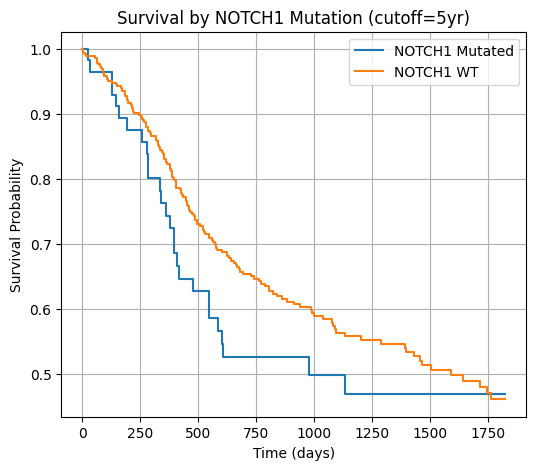

In [53]:
plot_km_with_cutoff(df, "NOTCH1")


### Binarize based on PolyPhen score

In [63]:
# Step 1: Extract max PolyPhen score per gene per patient
mutations['polyphen_score'] = mutations['PolyPhen'].str.extract(r"\(([\d.]+)\)").astype(float)

# Step 2: Filter to only mutations with high PolyPhen score
high_impact = mutations[mutations['polyphen_score'] > 0.85]

# Step 3: Create binary mutation matrix
binary_matrix = high_impact.groupby(['patient_id', 'Hugo_Symbol']) \
                           .size().unstack(fill_value=0)
binary_matrix = (binary_matrix > 0).astype(int)

# Step 4: Filter and merge
binary_matrix = binary_matrix.reset_index().set_index('patient_id')
features = binary_matrix.columns.tolist()
mutated_counts = binary_matrix[features].sum()
filtered_features = mutated_counts[mutated_counts >= 30].index.tolist()
binary_matrix = binary_matrix[filtered_features].copy()
df = pd.merge(metadata, binary_matrix, on="patient_id")
df = pd.get_dummies(df, columns=['gender'], drop_first=True)

In [48]:
cutoff = 5 * 365  # 5 years in days
km_results = []

for gene in filtered_features:
    try:
        if df[gene].nunique() < 2:
            continue  # skip if all 0 or all 1

        mutated = df[df[gene] == 1]
        wt = df[df[gene] == 0]

        # Apply 5-year cutoff
        mutated_cutoff = mutated.copy()
        wt_cutoff = wt.copy()

        mutated_cutoff["OS_time"] = mutated_cutoff["OS_time"].clip(upper=cutoff)
        wt_cutoff["OS_time"] = wt_cutoff["OS_time"].clip(upper=cutoff)

        mutated_cutoff["OS"] = mutated_cutoff["OS"].astype(bool) & (mutated_cutoff["OS_time"] < cutoff)
        wt_cutoff["OS"] = wt_cutoff["OS"].astype(bool) & (wt_cutoff["OS_time"] < cutoff)

        result = logrank_test(
            mutated_cutoff["OS_time"], wt_cutoff["OS_time"],
            event_observed_A=mutated_cutoff["OS"],
            event_observed_B=wt_cutoff["OS"]
        )
        km_results.append((gene, result.p_value))

    except Exception as e:
        print(f"⚠️ Skipping {gene}: {e}")
# Create sorted DataFrame
km_df = pd.DataFrame(km_results, columns=["gene", "p"])
km_df = km_df.sort_values("p")
from statsmodels.stats.multitest import multipletests

# Apply FDR correction
km_df["q"] = multipletests(km_df["p"], method="fdr_bh")[1]
km_df = km_df.sort_values("q")  # sort by FDR-adjusted p-values

# Preview top hits
print(km_df.head())

     gene         p         q
1  NOTCH1  0.000712  0.002848
3    TP53  0.457428  0.753797
2  PIK3CA  0.661039  0.753797
0   CSMD3  0.753797  0.753797


NOTCH1 log-rank p = 0.0007119


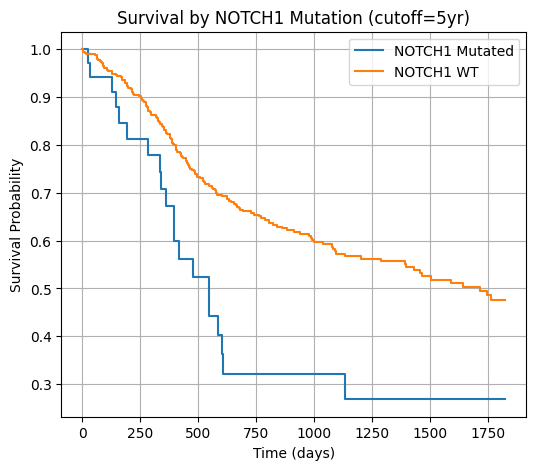

In [49]:
plot_km_with_cutoff(df, "NOTCH1")

### Binarize based on SIFT score

In [55]:
# Step 1: Extract SIFT score
mutations['sift_score'] = mutations['SIFT'].str.extract(r"\(([\d.]+)\)").astype(float)

# Step 2: Filter to only mutations with low SIFT score (more damaging)
# SIFT score < 0.05 is usually considered deleterious
high_impact = mutations[mutations['sift_score'] < 0.05]

# Step 3: Create binary mutation matrix
binary_matrix = high_impact.groupby(['patient_id', 'Hugo_Symbol']) \
                           .size().unstack(fill_value=0)
binary_matrix = (binary_matrix > 0).astype(int)

# Step 4: Filter and merge
binary_matrix = binary_matrix.reset_index().set_index('patient_id')
features = binary_matrix.columns.tolist()
mutated_counts = binary_matrix[features].sum()
filtered_features = mutated_counts[mutated_counts >= 30].index.tolist()
binary_matrix = binary_matrix[filtered_features].copy()
df = pd.merge(metadata, binary_matrix, on="patient_id")
df = pd.get_dummies(df, columns=['gender'], drop_first=True)


In [56]:
cutoff = 5 * 365  # 5 years in days
km_results = []

for gene in filtered_features:
    try:
        if df[gene].nunique() < 2:
            continue  # skip if all 0 or all 1

        mutated = df[df[gene] == 1]
        wt = df[df[gene] == 0]

        # Apply 5-year cutoff
        mutated_cutoff = mutated.copy()
        wt_cutoff = wt.copy()

        mutated_cutoff["OS_time"] = mutated_cutoff["OS_time"].clip(upper=cutoff)
        wt_cutoff["OS_time"] = wt_cutoff["OS_time"].clip(upper=cutoff)

        mutated_cutoff["OS"] = mutated_cutoff["OS"].astype(bool) & (mutated_cutoff["OS_time"] < cutoff)
        wt_cutoff["OS"] = wt_cutoff["OS"].astype(bool) & (wt_cutoff["OS_time"] < cutoff)

        result = logrank_test(
            mutated_cutoff["OS_time"], wt_cutoff["OS_time"],
            event_observed_A=mutated_cutoff["OS"],
            event_observed_B=wt_cutoff["OS"]
        )
        km_results.append((gene, result.p_value))

    except Exception as e:
        print(f"⚠️ Skipping {gene}: {e}")
# Create sorted DataFrame
km_df = pd.DataFrame(km_results, columns=["gene", "p"])
km_df = km_df.sort_values("p")
from statsmodels.stats.multitest import multipletests

# Apply FDR correction
km_df["q"] = multipletests(km_df["p"], method="fdr_bh")[1]
km_df = km_df.sort_values("q")  # sort by FDR-adjusted p-values

# Preview top hits
print(km_df.head())

     gene         p         q
1  NOTCH1  0.001453  0.005810
3    TP53  0.185812  0.371624
0   CSMD3  0.919941  0.994910
2  PIK3CA  0.994910  0.994910


NOTCH1 log-rank p = 0.001453


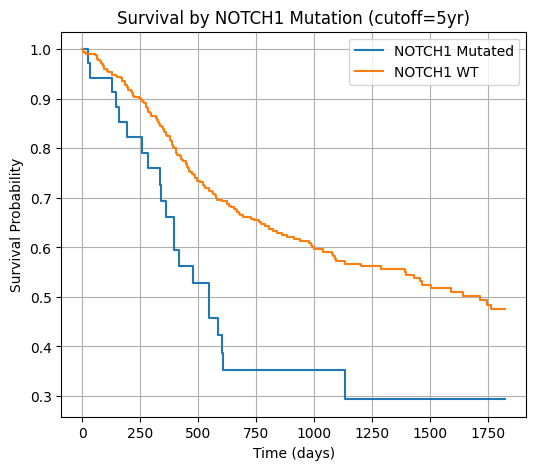

In [57]:
plot_km_with_cutoff(df, "NOTCH1")

### HR Analysis on selected gene

In [64]:
from lifelines import CoxPHFitter

# Subset to needed columns
data = df[['OS_time', 'OS', 'NOTCH1']].dropna()

# Fit Cox model
cph = CoxPHFitter()
cph.fit(data, duration_col='OS_time', event_col='OS')

# Show results
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 448 total observations, 245 right-censored observations>
             duration col = 'OS_time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 448
number of events observed = 203
   partial log-likelihood = -1083.33
         time fit was run = 2025-05-27 23:50:20 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
NOTCH1     0.75      2.11      0.24            0.28            1.21                1.33                3.36

           cmp to    z      p  -log2(p)
covariate                              
NOTCH1       0.00 3.15 <0.005      9.24
---
Concordance = 0.53
Partial AIC = 2168.66
log-likelihood ratio test = 8.18 on 1 df
-log2(p) of ll-ratio test = 7.88